In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

In [3]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

## Change the path to the pickled file

In [4]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/pickle_files/sim_tadpole9_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [5]:
pkl["samples_likelihood"].shape

(3000000, 1)

### Check that the MCI and CN/AD files have same column names

In [6]:
# MCI and CN/AD data
cn_ad_path = "/home/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm_final_n327.csv"
df_cnad = pd.read_csv(cn_ad_path)
mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm_mci.csv"
df_mci = pd.read_csv(mci_path)
df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
assert all(df_mci.columns == df_cnad.columns)

## Subtyping and Staging the subjects

### Get the probability matrices for CN/AD

In [7]:
# Get the mixture model for the CN/AD subjects
k=119
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdf(None, X[:, i])

L_no = process_L(L_no)
L_yes = process_L(L_yes)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


### Create a SuStaIn object to call the associated methods

In [8]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [25,25,25,25,19]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 8
p_absorb = 0.3
SuStaInLabels = df_cnad.columns[:k].tolist()
dataset_name            = 'sim_tadpole9'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, output_folder, dataset_name, use_parallel_startpoints)

### Get the prob mat for the mci subjects

In [9]:
# Get the prob mat for the mci subjects
X_mci = df_mci.iloc[:,:k].values
prob_mat_mci = mixture_model.get_prob_mat(X_mci, mixture_models)
L_no_mci = prob_mat_mci[:,:,0]
L_yes_mci = prob_mat_mci[:,:,1]
L_no_mci = process_L(L_no_mci)
L_yes_mci = process_L(L_yes_mci)

### Subtype and Stage the MCI subjects

In [10]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_newData = sEBMSustainData(L_yes_mci, L_no_mci, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci = sustain.subtype_and_stage_individuals(sustainData_newData, shape_seq, samples_sequence, samples_f, N_samples)


### Subtype and Stage CN/AD data

In [11]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence, samples_f, N_samples)


In [12]:
n_cnad = ml_subtype_cnad.shape[0]
n_mci = ml_subtype_mci.shape[0]
unique_cnad, counts_cnad = np.unique(ml_subtype_cnad, return_counts=True)
unique_mci, counts_mci = np.unique(ml_subtype_mci, return_counts=True)

fraction_cnad = {}
dict_cnad = dict(zip(unique_cnad, counts_cnad))
for k, v in dict_cnad.items():
    fraction_cnad[k] = v/n_cnad
    
fraction_mci = {}
dict_mci = dict(zip(unique_mci, counts_mci))
for k, v in dict_mci.items():
    fraction_mci[k] = v/n_mci
    
print("CN/AD fractions across subtypes : \n", fraction_cnad)
print("MCI fractions across subtypes : \n", fraction_mci)

CN/AD fractions across subtypes : 
 {0.0: 0.5168195718654435, 1.0: 0.290519877675841, 2.0: 0.1162079510703364, 3.0: 0.0764525993883792}
MCI fractions across subtypes : 
 {0.0: 0.3466424682395644, 1.0: 0.27404718693284935, 2.0: 0.1542649727767695, 3.0: 0.2250453720508167}


### Get subjects for a givensubtype

### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [13]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.values.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
cnad_solved[["PTID", "EXAMDATE"]] = df_cnad[["PTID", "EXAMDATE"]]

In [14]:
# DataFrame for MCI subjects
array_subtype_stage_mci = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_solved = pd.DataFrame(data=array_subtype_stage_mci, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
mci_solved[["PTID", "EXAMDATE"]] = df_mci[["PTID", "EXAMDATE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [15]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"MCI"})

In [16]:
subtype_select = 0.0
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","MCI"]).reset_index()

In [17]:
final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)

DX,AD,Controls,MCI
stage,,,
0.0,0.0,0.0,39.0
1.0,9.0,43.0,40.0
2.0,15.0,29.0,29.0
3.0,39.0,4.0,51.0
4.0,26.0,4.0,27.0
5.0,0.0,0.0,5.0


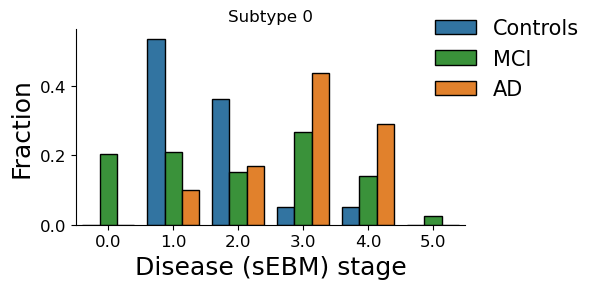

In [18]:
fig, ax = plt.subplots(figsize=(6,3))
hue_order=["Controls", "MCI", "AD"]
palette = ["C0", "C2","C1"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("Disease (sEBM) stage", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title="", fontsize=15, framealpha=0.0, loc=(0.9,0.6))
ax.set_title("Subtype {}".format(int(subtype_select)))
# ax.text(s=r"p-value ($\chi^{2}$) < 1 x $10^{-18}$ ",x=1.0,y=0.5, fontsize=15)
sns.despine()
plt.tight_layout()
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures"
fname = "stage_hist_subtype_{}.png".format(int(subtype_select))
fig.savefig(os.path.join(fig_path, fname), dpi=300, transparent=True)


# Progression curves

In [19]:
cmap = cm.get_cmap('autumn_r')
delta_years = list(range(5,8))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

## Prepare longitudinal data

In [20]:
def prepare_logitudinal_data(first_visit_df):
    # Read the MRI data across all subjects
    path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm.csv"
    df = pd.read_csv(path)
    sid = df["Measure:volume"].apply(lambda x: x.split("-",1))
    df_sid = pd.DataFrame(sid.tolist(), columns=["sid", "time"])
    sid_time = df_sid["time"].apply(lambda x: x.split("_",1))
    df_sid_time = pd.DataFrame(sid_time.tolist(), columns=["date", "time"])
    df_concat = pd.concat([df_sid, df_sid_time], axis=1)[["sid", "date"]]
    df_concat["date"] = pd.to_datetime(df_concat["date"])

    # Read the ADNIMERGE file     
    adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
    df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]
    df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])
    merged_df = df_adnimerge.merge(df_concat, left_on=["PTID", "EXAMDATE"], right_on=["sid", "date"])
    
    # longitudinal_records
    longitudinal_records = df_adnimerge.sort_values(["PTID", "EXAMDATE"]).set_index("PTID").dropna(subset=["DX"])
    d = {}
    for i, row in first_visit_df.iterrows():
        ptid = row["PTID"]
        d[ptid] = longitudinal_records.loc[ptid, :]
    return d, merged_df
    

In [21]:
d, merged_df = prepare_logitudinal_data(final_df)
mci_demographics = merged_df[merged_df["DX"].isin(["MCI"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")
cn_demographics = merged_df[merged_df["DX"].isin(["CN"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

<ipython-input-20-2b455cddab5a>:14: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]


In [22]:
Su = 0.0
mci_subtype = mci_solved[mci_solved["subtype"]==Su]
fraction = mci_subtype.shape[0]/mci_solved.shape[0]
cox_mci = mci_demographics[mci_demographics["PTID"].isin(mci_subtype["PTID"])]
dict_stage = dict(zip(mci_subtype["PTID"],mci_subtype["stage"]))

<ipython-input-34-73d2a169fe0c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mci_subtype["convert"] = mci_subtype["PTID"].map(d2)
<ipython-input-34-73d2a169fe0c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_mci["convert"] = cox_mci["PTID"].map(d2)
<ipython-input-34-73d2a169fe0c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

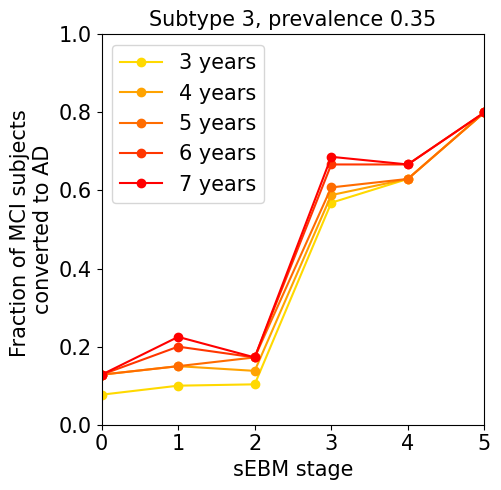

In [34]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,8))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))
save_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures"

for dy in delta_years:
    d2 = {}
    dtd = {}
    for i, row in mci_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=dy, months=0)
        ptid_df = d[ptid].sort_values(["EXAMDATE"])
        ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                            & (ptid_df["EXAMDATE"] <= examdate_max)]
        srs = ptid_forward_df["DX"]
        if type(srs) is str:
            cnvrt = 0
        else:
            first_dx = srs[0]
            assert first_dx == "MCI"
            bool_srs = srs == "Dementia"
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]
        dtd[ptid] = time_delta.days
        d2[ptid] = cnvrt

    mci_subtype["convert"] = mci_subtype["PTID"].map(d2)
    df_convert = mci_subtype[mci_subtype["convert"]==1]
    dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(dfc["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(mci_subtype["stage"])
    d3 = {}
    for i in range(6):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d3[i]=r
    # print(stats.kendalltau(list(d3.keys()), list(d3.values())))
    x = np.array(list(d3.keys()))
    y = np.array(list(d3.values()))
    ax.plot(x, y, label=str(dy) + " years", marker="o", color=d_colors[dy])
    ax.set_xlabel("sEBM stage", fontsize=15)
    cox_mci["convert"] = cox_mci["PTID"].map(d2)
    cox_mci["time"] = cox_mci["PTID"].map(dtd)
    cox_mci["subtype"] = Su
    cox_mci["stages_inferred"] = cox_mci["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}.csv".format(Su,dy)
    cox_mci.to_csv(os.path.join(save_path,fname))
    
ax.set_ylabel("Fraction of MCI subjects \nconverted to AD", fontsize=15)
ax.set_title("Subtype {}, prevalence {}".format(int(Su), np.round(fraction, 2)), 
             fontsize=15)
ax.set_xlim([0,5])
ax.set_ylim([0,1])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=15)
plt.tight_layout()
# plt.xlim([0,6])
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc=2)
fig_name = "mci_subtype_{}.png".format(Su)
fig.savefig(os.path.join(save_path, fig_name), dpi=300)


## Controls progression

In [24]:
d, merged_df = prepare_logitudinal_data(final_df)
cn_demographics = merged_df[merged_df["DX_bl"].isin(["CN"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

<ipython-input-20-2b455cddab5a>:14: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]


In [25]:
merged_df

,PTID,DX_bl,DX,EXAMDATE,VISCODE,AGE,PTGENDER,PTEDUCAT,APOE4,sid,date
0,011_S_0003,AD,Dementia,2006-03-13,m06,81.3,Male,18,1.0,011_S_0003,2006-03-13
1,011_S_0003,AD,Dementia,2006-09-12,m12,81.3,Male,18,1.0,011_S_0003,2006-09-12
2,011_S_0003,AD,Dementia,2007-09-12,m24,81.3,Male,18,1.0,011_S_0003,2007-09-12
3,011_S_0005,CN,CN,2006-03-09,m06,73.7,Male,16,0.0,011_S_0005,2006-03-09
4,011_S_0005,CN,CN,2006-09-05,m12,73.7,Male,16,0.0,011_S_0005,2006-09-05
...,...,...,...,...,...,...,...,...,...,...,...
2714,013_S_1276,CN,CN,2010-04-20,m36,71.8,Female,14,0.0,013_S_1276,2010-04-20
2715,031_S_4021,CN,NaN,2011-07-26,m03,66.5,Male,20,0.0,031_S_4021,2011-07-26
2716,031_S_4021,CN,CN,2011-10-20,m06,66.5,Male,20,0.0,031_S_4021,2011-10-20
2717,031_S_4021,CN,CN,2012-04-26,m12,66.5,Male,20,0.0,031_S_4021,2012-04-26


In [32]:
Su = 3.0
cn_subtype = cnad_solved[(cnad_solved["subtype"]==Su) & (cnad_solved["DX"]==0.0)]
fraction_cn = cn_subtype.shape[0]/cnad_solved[cnad_solved["DX"]==0.0].shape[0]
cox_cn = cn_demographics[cn_demographics["PTID"].isin(cn_subtype["PTID"])]
dict_stage = dict(zip(cn_subtype["PTID"],cn_subtype["stage"]))

<ipython-input-33-054c5f66aab4>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cn_subtype["convert"] = cn_subtype["PTID"].map(d2)
<ipython-input-33-054c5f66aab4>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_cn["convert"] = cox_cn["PTID"].map(d2)
<ipython-input-33-054c5f66aab4>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

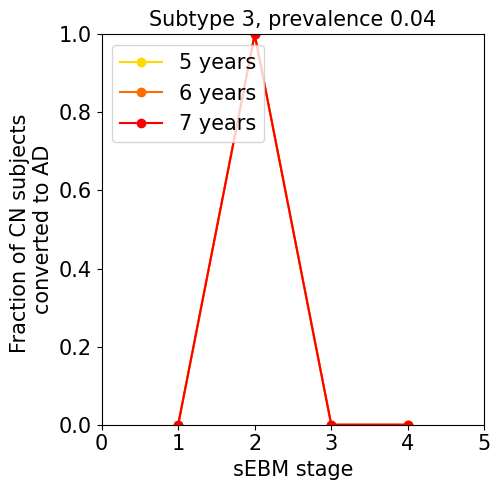

In [33]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(5,8))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))
save_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures"

for dy in delta_years:
    d2 = {}
    dtd = {}
    for i, row in cn_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=dy, months=0)
        ptid_df = d[ptid].sort_values(["EXAMDATE"])
        ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                            & (ptid_df["EXAMDATE"] <= examdate_max)]
        srs = ptid_forward_df["DX"]
        if type(srs) is str:
            cnvrt = 0
        else:
            first_dx = srs[0]
            assert first_dx == "CN"
            bool_srs = srs != first_dx
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]
        dtd[ptid] = time_delta.days
        d2[ptid] = cnvrt

    cn_subtype["convert"] = cn_subtype["PTID"].map(d2)
    df_convert = cn_subtype[cn_subtype["convert"]==1]
    dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(dfc["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(cn_subtype["stage"])
    d3 = {}
    for i in range(6):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d3[i]=r
    # print(stats.kendalltau(list(d3.keys()), list(d3.values())))
    x = np.array(list(d3.keys()))
    y = np.array(list(d3.values()))
    ax.plot(x, y, label=str(dy) + " years", marker="o", color=d_colors[dy])
    ax.set_xlabel("sEBM stage", fontsize=15)
    cox_cn["convert"] = cox_cn["PTID"].map(d2)
    cox_cn["time"] = cox_cn["PTID"].map(dtd)
    cox_cn["subtype"] = Su
    cox_cn["stages_inferred"] = cox_cn["PTID"].map(dict_stage)
    fname = "CN_cox_df_subtype_{}_delta_yrs_{}.csv".format(Su,dy)
    cox_cn.to_csv(os.path.join(save_path,fname))
    
ax.set_ylabel("Fraction of CN subjects \nconverted to AD", fontsize=15)
ax.set_title("Subtype {}, prevalence {}".format(int(Su), np.round(fraction_cn, 2)), 
             fontsize=15)
ax.set_xlim([0,5])
ax.set_ylim([0,1.0])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=15)
plt.tight_layout()
# plt.xlim([0,6])
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc=2)
fig_name = "cn_subtype_{}.png".format(Su)
fig.savefig(os.path.join(save_path, fig_name), dpi=300)


## Longitudinal data analysis

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [ ]:
df_long.shape

In [ ]:
len(set(df_long["sid"]))

In [ ]:
327 + 551

In [ ]:
df_long.shape

In [ ]:
set(final_df["PTID"]) - set(df_long["sid"])

In [ ]:
len(set(final_df["PTID"]))

In [ ]:
all(df_long.columns[:119] == df_cnad.columns[:119])

In [ ]:
### List of CN/AD and MCI subjects

In [ ]:
# mci_subj_0 = mci_solved[mci_solved["subtype"]==0.0]["PTID"].tolist()
# mci_subj_1 = mci_solved[mci_solved["subtype"]==1.0]["PTID"].tolist()

In [ ]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [ ]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [ ]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)


In [ ]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])

In [ ]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_long_subtype_stage = pd.DataFrame(mci_long_subtype_stage, columns=["subtype", "stage"])
mci_long_subtype_stage[["sid", "date"]] = df_long_mci.reset_index()[["sid", "date"]]
mci_long_subtype_stage["date"] = pd.to_datetime(mci_long_subtype_stage["date"])
df_followup = mci_long_subtype_stage
df_followup = df_followup.sort_values(["sid", "date"])

In [ ]:
df_followup

In [ ]:
def get_pairs(vec):
    trns = []
    l = vec.shape[0]
    for i in range(1,l):
        trns.append((vec[:i][-1], vec[i:][0]))
    return trns

sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["subtype"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [ ]:
count = np.zeros((4,4))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':15})
ax.set_ylabel("sEBM subtype in previous visit", fontsize=15)
ax.set_xlabel("sEBM subtype in next visit", fontsize=15)
fig_name = "longitudinal_subtype_followup_visit.png"
fig.savefig(os.path.join(save_path, fig_name), dpi=300, transparent=True)

In [ ]:
count.trace() , count.sum()

In [ ]:
count.trace()/count.sum()

In [ ]:
x_ = np.array([0.35,0.27,0.15,0.23])
np.dot(x_,x_)

In [ ]:
mci_long_subtype_stage[["sid", "date"]]

In [ ]:
df_long_mci

In [ ]:
mci_demographics, mci_solved

In [ ]:
mci_solved["EXAMDATE"]

In [ ]:
mci_demo_full = pd.merge(mci_demographics, mci_solved, on=["PTID", "EXAMDATE"])

In [ ]:
mci_solved

In [ ]:
final_df

In [ ]:
mci_demo_full.head()

In [ ]:
mci_demo_full

In [ ]:
mci_demo_full.groupby(["subtype", "APOE4"]).size()

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='stage', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_demographics = merged_df[merged_df["DX"].isin(["CN", "MCI", "Dementia"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
len(set(all_demographics["PTID"]))

In [ ]:
all_demographics

In [ ]:
all_data = pd.merge(all_demographics, final_df, on=["PTID", "EXAMDATE"])

In [ ]:
all_data.pivot_table(index='subtype', columns='DX_x', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data[all_data["DX_x"].isin(["CN", "Dementia"])].pivot_table(index='subtype', columns='PTGENDER', 
                        aggfunc=len, fill_value=0)["PTID"]